# DL(w11) VAE
student ID: 7110018036\
name: Chieh-An, Chou

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-16 20:34:45.753284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

x_train_set = x_train_set/255.0
x_test = x_test/255.0

In [3]:
# (check data)
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

2


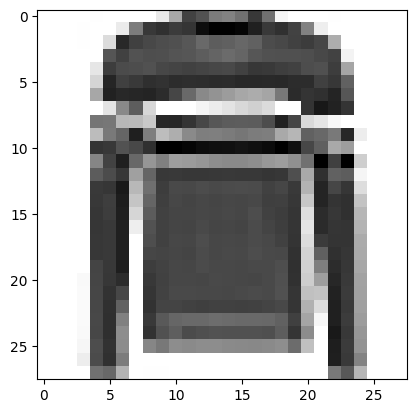

In [4]:
i = 5
print(y_train_set[i])
plt.imshow(x_train_set[i], cmap='binary')
plt.show()

In [5]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_set, y_train_set, random_state = 1)

## Variational Autoencoder

### 1. Build Model

Sampling Layer: coding $\mu$ and $\log\mathbf{\sigma}^2$ -> sampling
+ $\sigma = \exp(\log\mathbf{\sigma}^2/2)$, 使用log因其在訓練上更有效率
+ $\mathbf{z}=\mathbf{\mu}+ \mathbf{\epsilon}\otimes\exp(\log\mathbf{\sigma}^2/2)$

In [6]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        e = tf.random.normal(tf.shape(log_var))
        return mean + e*tf.math.exp(log_var / 2)  

In [7]:
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

In [8]:
d = 10

# functional API 
in_en = keras.layers.Input(shape=[28, 28])
c = keras.layers.Flatten()(in_en)
c = keras.layers.Dense(150, activation="selu")(c)
c = keras.layers.Dense(100, activation="selu")(c)
# c need to be the inputs of c_mean and c_log_var at the same time.
c_mean = keras.layers.Dense(d)(c)
c_log_var = keras.layers.Dense(d)(c)
out_en = Sampling()([c_mean, c_log_var])

var_encoder = keras.models.Model(
    inputs=[in_en], outputs=[out_en])

2023-05-16 20:34:47.872664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 20:34:47.895970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 20:34:47.896077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 20:34:47.896386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

+ Latent Layer:
    + coding $\mu$: `dense_2` (<- `dense_1`)
    + coding $\log\sigma^2$: `dense_3` (<- `dense_1`)
    + Sampling: `Sampling` (<- `dense_2` & `dense_3`)

In [9]:
var_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 150)          117750      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          15100       ['dense[0][0]']                  
                                                                                              

In [10]:
in_de = keras.layers.Input(shape=[d]) # from latent space
x = keras.layers.Dense(100, activation="selu")(in_de)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
out_de = keras.layers.Reshape([28, 28])(x)

var_decoder = keras.models.Model(inputs=[in_de], outputs=[out_de])

In [11]:
var_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 150)               15150     
                                                                 
 dense_6 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


In [12]:
codings = var_encoder(in_en)
rec = var_decoder(codings)

var_ae = keras.models.Model(inputs=[in_en], outputs=[rec])

In [13]:
var_ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 model (Functional)          (None, 10)                134870    
                                                                 
 model_1 (Functional)        (None, 28, 28)            134634    
                                                                 
Total params: 269,504
Trainable params: 269,504
Non-trainable params: 0
_________________________________________________________________


### 2. Compile

In [15]:
D_KL = -0.5 * tf.math.reduce_sum(
    1 + c_log_var - tf.math.exp(c_log_var) - tf.math.square(c_mean),
    axis=1)
latent_loss = tf.math.reduce_mean(D_KL) / 784.0 # to match the scale of binary_crossentropy
var_ae.add_loss(latent_loss)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) # 0~1 -> 0,1

var_ae.compile(loss="binary_crossentropy",
               optimizer="rmsprop", 
               metrics=[rounded_accuracy])

### 3. Train 

In [16]:
train = var_ae.fit(x_train, x_train, epochs=20, batch_size=256,
                   validation_data=(x_valid, x_valid))

Epoch 1/20


2023-05-16 20:51:21.016551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-16 20:51:21.150000: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562af952cb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 20:51:21.150065: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-16 20:51:21.195394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-16 20:51:21.521813: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 [==============================] - 5s 13ms/step - loss: 0.4596 - rounded_accuracy: 0.7938 - val_loss: 0.3985 - val_rounded_accuracy: 0.8550
Epoch 2/20
176/176 [==============================] - 1s 8ms/step - loss: 0.3878 - rounded_accuracy: 0.8617 - val_loss: 0.3683 - val_rounded_accuracy: 0.8811
Epoch 3/20
176/176 [==============================] - 1s 3ms/step - loss: 0.3655 - rounded_accuracy: 0.8817 - val_loss: 0.3561 - val_rounded_accuracy: 0.8836
Epoch 4/20
176/176 [==============================] - 1s 3ms/step - loss: 0.3553 - rounded_accuracy: 0.8893 - val_loss: 0.3550 - val_rounded_accuracy: 0.8868
Epoch 5/20
176/176 [==============================] - 1s 3ms/step - loss: 0.3498 - rounded_accuracy: 0.8932 - val_loss: 0.3425 - val_rounded_accuracy: 0.9000
Epoch 6/20
176/176 [==============================] - 1s 3ms/step - loss: 0.3455 - rounded_accuracy: 0.8965 - val_loss: 0.3420 - val_rounded_accuracy: 0.9000
Epoch 7/20
176/176 [==============================] - 1s 3ms/s

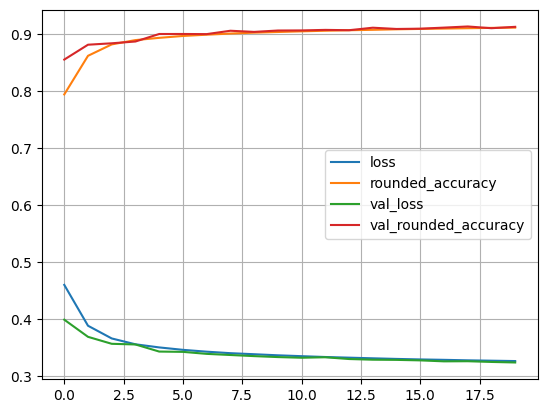

In [17]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

### 4. Evaluate

In [18]:
var_ae.evaluate(x_test, x_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3263 - rounded_accuracy: 0.9110


[0.3262733221054077, 0.9110323786735535]

### 5. Predict (Reconstruct)

In [19]:
x_test_decoded = var_ae.predict(x_test)

313/313 [==============================] - 0s 961us/step


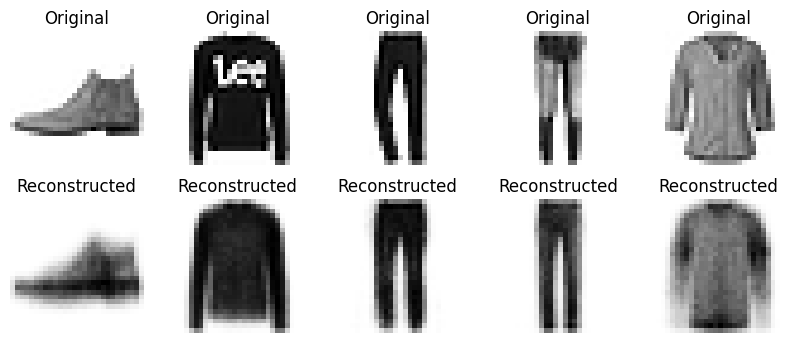

In [20]:
plt.figure(figsize=(10, 4))

for i in range(5):
    plt.subplot(2, 5, 1 + i)
    plt.imshow(x_test[i], cmap='binary')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, 1+ 5 + i)
    plt.imshow(x_test_decoded[i], cmap='binary')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

## Generate Fashion Images

In [21]:
tf.random.set_seed(1)

random_codings = tf.random.normal(shape=[5, d])
imgs = var_decoder(random_codings)

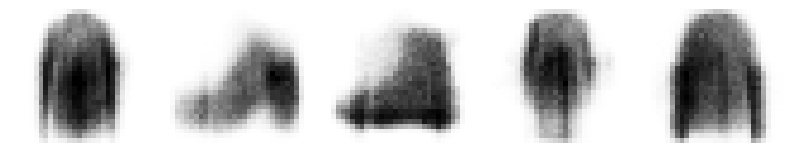

In [22]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, 1 + i)
    plt.imshow(imgs[i], cmap='binary')
    plt.axis('off')
plt.show()